In [2]:
import os
import shutil
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path(os.path.join("..", "..", "dataset", "cats_vs_dogs_small"))


image_size = (180, 180)
batch_size = 32
train_dataset = image_dataset_from_directory(
    new_base_dir / "train", image_size=image_size, batch_size=batch_size
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", image_size=image_size, batch_size=batch_size
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test", image_size=image_size, batch_size=batch_size
)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
)
print("Before freezing:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("After freezing:", len(conv_base.trainable_weights))

Before freezing: 26
After freezing: 0


In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.1),
        preprocessing.RandomZoom(0.2)
    ]
)

In [15]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0   

In [17]:
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"],
)


In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]


In [19]:

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/50


2022-10-06 14:25:22.717452: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-06 14:25:23.491312: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


63/63 [==============================] - 36s 466ms/step - loss: 14.0678 - accuracy: 0.8920 - val_loss: 4.9849 - val_accuracy: 0.9660
Epoch 2/50
63/63 [==============================] - 28s 449ms/step - loss: 4.6102 - accuracy: 0.9565 - val_loss: 6.3876 - val_accuracy: 0.9620
Epoch 3/50
63/63 [==============================] - 29s 454ms/step - loss: 4.0726 - accuracy: 0.9640 - val_loss: 3.9393 - val_accuracy: 0.9760
Epoch 4/50
63/63 [==============================] - 28s 449ms/step - loss: 4.2867 - accuracy: 0.9650 - val_loss: 3.5278 - val_accuracy: 0.9750
Epoch 5/50
63/63 [==============================] - 28s 443ms/step - loss: 3.9298 - accuracy: 0.9725 - val_loss: 4.1656 - val_accuracy: 0.9760
Epoch 6/50
63/63 [==============================] - 29s 454ms/step - loss: 2.4722 - accuracy: 0.9790 - val_loss: 6.8424 - val_accuracy: 0.9610
Epoch 7/50
63/63 [==============================] - 28s 439ms/step - loss: 2.7440 - accuracy: 0.9755 - val_loss: 3.4822 - val_accuracy: 0.9740
Epoch 8/5

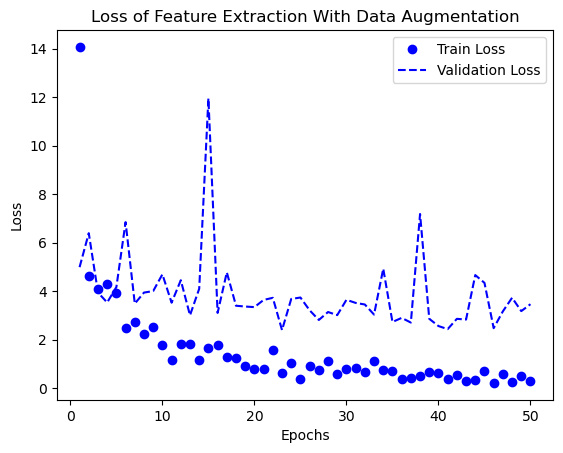

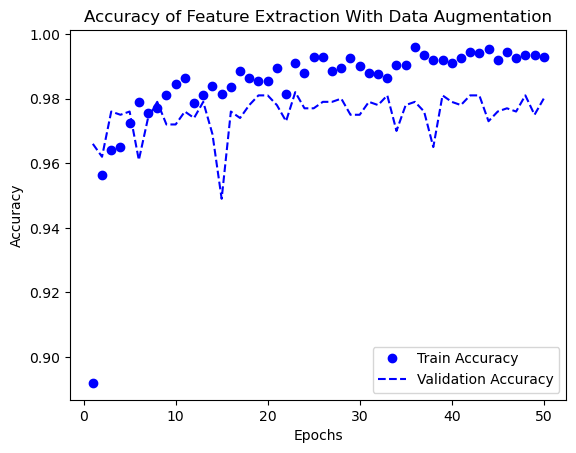

In [22]:
import matplotlib.pyplot as plt

x_range = range(1, 51)
plt.plot(x_range, history.history["loss"], "bo", label="Train Loss")
plt.plot(x_range, history.history["val_loss"], "b--", label="Validation Loss")
plt.title("Loss of Feature Extraction With Data Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.plot(x_range, history.history["accuracy"], "bo", label="Train Accuracy")
plt.plot(x_range, history.history["val_accuracy"], "b--", label="Validation Accuracy")
plt.title("Accuracy of Feature Extraction With Data Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
